# Import library

In [5]:
import os
import sys
import glob
import re
import datetime
from datetime import datetime, timedelta 
import math, copy, time
from itertools import cycle
from collections import defaultdict

from parse import parse
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

# import torchvision
# import torchvision.transforms as transforms

from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn import svm


from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn

%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
pd.set_option("display.max_column", 100)
pd.set_option("display.max_row", 100)

In [7]:
# Util functions
def size_and_ratio(df, col, dropna=True):
    if pd.__version__ > '1.1':
        sr = df.groupby(col, dropna=dropna).size().sort_values(ascending=False)
    elif dropna:
        sr = df.groupby(col).size().sort_values(ascending=False)
    else:  # dropna == False
        sr = df.fillna('nan').groupby(col).size().sort_values(ascending=False)
    sr_ratio = sr.copy() / sum(sr)
    print("Sum :", sum(sr), sr.shape)
    sr.name = 'size'
    sr_ratio.name = 'ratio'
    return pd.concat([sr, sr_ratio], axis=1)

# Data load

In [89]:
df_all = pd.read_csv("../pipeline/output/shine_v3_5_kt/df_all_added_owid.csv")

In [90]:
size_and_ratio(df_all, 'pcr_result')

Sum : 15351 (2,)


,size,ratio
pcr_result,,
1,10232,0.666536
0,5119,0.333464


In [91]:
size_and_ratio(df_all, 'split')

Sum : 15351 (3,)


,size,ratio
split,,
TRAIN,9148,0.595922
VALIDATE,3163,0.206045
TEST,3040,0.198033


In [92]:
df_all[df_all['patient_id'] == 30888]

,patient_id,selfcheck_date,pcr_date,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,sigungu_confirmed_mask,indication_other,indication_abroad,indication_contact,gender,age_ratio,age_60_and_above,smoking,hx_covid_result,hx_covid_date,weekday,selfcheck_reason,scReason1,scReason2,scReason3,scReason4,scReason5,scReason6,scReason7,scReason8,scReason9,scReason10,pcr_result,split,iso_code,date,total_cases_per_million_norm,total_cases_per_million_mask,new_cases_per_million_norm,new_cases_per_million_mask,new_cases_smoothed_per_million_norm,new_cases_smoothed_per_million_mask,total_deaths_per_million_norm,total_deaths_per_million_mask,new_deaths_per_million_norm,new_deaths_per_million_mask,new_deaths_smoothed_per_million_norm,new_deaths_smoothed_per_million_mask,icu_patients_per_million_norm,icu_patients_per_million_mask,hosp_patients_per_million_norm,hosp_patients_per_million_mask,weekly_icu_admissions_per_million_norm,weekly_icu_admissions_per_million_mask,weekly_hosp_admissions_per_million_norm,weekly_hosp_admissions_per_million_mask,total_tests_per_thousand_norm,total_tests_per_thousand_mask,new_tests_per_thousand_norm,new_tests_per_thousand_mask,new_tests_smoothed_per_thousand_norm,new_tests_smoothed_per_thousand_mask,total_vaccinations_per_hundred_norm,total_vaccinations_per_hundred_mask,people_vaccinated_per_hundred_norm,people_vaccinated_per_hundred_mask,people_fully_vaccinated_per_hundred_norm,people_fully_vaccinated_per_hundred_mask,total_boosters_per_hundred_norm,total_boosters_per_hundred_mask,new_vaccinations_smoothed_per_million_norm,new_vaccinations_smoothed_per_million_mask,new_people_vaccinated_smoothed_per_hundred_norm,new_people_vaccinated_smoothed_per_hundred_mask,hospital_beds_per_thousand_norm,hospital_beds_per_thousand_mask,excess_mortality_cumulative_per_million_norm,excess_mortality_cumulative_per_million_mask,total_cases_per_million_for_6months_norm,total_cases_per_million_for_6months_mask,total_vaccinations_per_hundred_for_6months_norm,total_vaccinations_per_hundred_for_6months_mask,total_deaths_per_million_for_6months_norm,total_deaths_per_million_for_6months_mask
434,30888,2022-03-04,2022-02-28,1,0,1,0,1,1,1,1,0,0,1,1,1.073988,2.073168,0.076653,1,1,0,0,1.0,0.55,0.0,0,0,NaN,0,1,1,0,0,0,0,0,0,0,0,0,0,TRAIN,KOR,2022-03-04,0.105194,0.0,0.022502,0.0,0.095740,0.0,0.025685,0.0,0.005947,0.0,0.014781,0.0,0.085131,0.0,0.000000,1.0,0.0,1.0,0.330019,0.0,0.040748,0.0,0.031652,0.0,0.096766,0.0,0.568216,0.0,0.666538,0.0,0.670817,0.0,0.408321,0.0,0.014362,0.0,0.000427,0.0,0.88913,0.0,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0
1173,30888,2022-03-10,2022-03-10,1,0,0,0,0,0,0,0,0,0,0,0,1.248952,4.220764,0.125279,1,1,0,0,1.0,0.55,0.0,2,0,NaN,3,4,0,0,0,1,0,0,0,0,0,0,0,TRAIN,KOR,2022-03-10,0.147218,0.0,0.027619,0.0,0.136820,0.0,0.028876,0.0,0.006587,0.0,0.023224,0.0,0.118888,0.0,0.000000,1.0,0.0,1.0,0.352094,0.0,0.043451,0.0,0.023376,0.0,0.102390,0.0,0.569791,0.0,0.666847,0.0,0.671211,0.0,0.411909,0.0,0.010784,0.0,0.000598,0.0,0.88913,0.0,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0
5361,30888,2022-04-06,2022-04-06,1,0,0,0,0,0,0,0,0,0,0,0,0.814378,3.352451,0.296869,1,1,0,0,1.0,0.55,0.0,2,0,NaN,2,1,1,0,0,0,0,0,0,0,0,0,0,TRAIN,KOR,2022-04-06,0.386766,0.0,0.024136,0.0,0.131677,0.0,0.053983,0.0,0.011861,0.0,0.040399,0.0,0.120487,0.0,0.000000,1.0,0.0,1.0,0.297642,0.0,0.052470,0.0,0.013290,0.0,0.050060,0.0,0.575597,0.0,0.668010,0.0,0.672393,0.0,0.425600,0.0,0.005098,0.0,0.000683,0.0,0.88913,0.0,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0
7506,30888,2022-08-04,2022-08-04,1,0,0,0,0,0,0,0,0,0,0,0,0.970721,1.683333,0.000000,1,1,0,0,1.0,0.55,0.0,0,0,NaN,3,1,1,0,0,0,0,0,0,0,0,0,0,TRAIN,KOR,2022-08-04,0.535761,0.0,0.009094,0.0,0.046262,0.0,0.075270,0.0,0.001087,0.0,0.003471,0.0,0.033115,0.0,0.034848,0.0,0.0,1.0,0.067535,0.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.606451,0.0,0.669249,0.0,0.674285,0.0,0.506

In [93]:
# baby_id 하나에 여러케이스 있는 경우 체크
df_negative = df_all[df_all['pcr_result'] == 0]
sample = df_negative['patient_id'].sample(15)
for p_id in sample:
    print(p_id, df_negative[df_negative['patient_id'] == p_id].shape)

49919 (11, 92)
57367 (4, 92)
22149 (2, 92)
47531 (1, 92)
22819 (1, 92)
63354 (3, 92)
39805 (3, 92)
36365 (1, 92)
39813 (7, 92)
20616 (1, 92)
29175 (28, 92)
28943 (1, 92)
57413 (1, 92)
51364 (1, 92)
35373 (1, 92)


In [94]:
df_all[df_all['pcr_result'] == 0].sample(10)

,patient_id,selfcheck_date,pcr_date,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,sigungu_confirmed_mask,indication_other,indication_abroad,indication_contact,gender,age_ratio,age_60_and_above,smoking,hx_covid_result,hx_covid_date,weekday,selfcheck_reason,scReason1,scReason2,scReason3,scReason4,scReason5,scReason6,scReason7,scReason8,scReason9,scReason10,pcr_result,split,iso_code,date,total_cases_per_million_norm,total_cases_per_million_mask,new_cases_per_million_norm,new_cases_per_million_mask,new_cases_smoothed_per_million_norm,new_cases_smoothed_per_million_mask,total_deaths_per_million_norm,total_deaths_per_million_mask,new_deaths_per_million_norm,new_deaths_per_million_mask,new_deaths_smoothed_per_million_norm,new_deaths_smoothed_per_million_mask,icu_patients_per_million_norm,icu_patients_per_million_mask,hosp_patients_per_million_norm,hosp_patients_per_million_mask,weekly_icu_admissions_per_million_norm,weekly_icu_admissions_per_million_mask,weekly_hosp_admissions_per_million_norm,weekly_hosp_admissions_per_million_mask,total_tests_per_thousand_norm,total_tests_per_thousand_mask,new_tests_per_thousand_norm,new_tests_per_thousand_mask,new_tests_smoothed_per_thousand_norm,new_tests_smoothed_per_thousand_mask,total_vaccinations_per_hundred_norm,total_vaccinations_per_hundred_mask,people_vaccinated_per_hundred_norm,people_vaccinated_per_hundred_mask,people_fully_vaccinated_per_hundred_norm,people_fully_vaccinated_per_hundred_mask,total_boosters_per_hundred_norm,total_boosters_per_hundred_mask,new_vaccinations_smoothed_per_million_norm,new_vaccinations_smoothed_per_million_mask,new_people_vaccinated_smoothed_per_hundred_norm,new_people_vaccinated_smoothed_per_hundred_mask,hospital_beds_per_thousand_norm,hospital_beds_per_thousand_mask,excess_mortality_cumulative_per_million_norm,excess_mortality_cumulative_per_million_mask,total_cases_per_million_for_6months_norm,total_cases_per_million_for_6months_mask,total_vaccinations_per_hundred_for_6months_norm,total_vaccinations_per_hundred_for_6months_mask,total_deaths_per_million_for_6months_norm,total_deaths_per_million_for_6months_mask
698,24960,2022-03-07,2022-03-05,0,0,0,0,0,0,0,0,0,0,0,0,0.861346,3.633626,0.000000,1,1,0,0,0.0,0.36,0.0,1,0,NaN,5,1`7,1,0,0,0,0,0,1,0,0,0,0,TRAIN,KOR,2022-03-07,0.124026,0.0,0.017768,0.0,0.113452,0.0,0.027230,0.0,0.004445,0.0,0.019254,0.0,0.102012,0.0,0.000000,1.0,0.070256,0.0,0.325877,0.0,0.041863,0.0,0.018246,0.0,0.098013,0.0,0.568979,0.0,0.666692,0.0,0.670975,0.0,0.410049,0.0,0.010895,0.0,0.000427,0.0,0.88913,0.0,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0
1750,26738,2022-03-15,2022-03-14,0,0,0,0,0,0,0,0,0,0,0,0,1.333682,5.404349,0.127544,1,1,0,0,0.0,0.33,0.0,1,0,NaN,0,1,1,0,0,0,0,0,0,0,0,0,0,TRAIN,KOR,2022-03-15,0.192101,0.0,0.030552,0.0,0.174627,0.0,0.032594,0.0,0.009368,0.0,0.029790,0.0,0.127754,0.0,0.283196,0.0,0.000000,1.0,0.366431,0.0,0.046048,0.0,0.037133,0.0,0.112897,0.0,0.571193,0.0,0.667157,0.0,0.671605,0.0,0.415099,0.0,0.009444,0.0,0.000598,0.0,0.88913,0.0,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0
11200,54802,2022-04-13,2022-04-13,0,0,0,0,0,0,0,0,0,0,0,0,0.717621,2.213733,0.000000,1,1,0,0,1.0,0.36,0.0,0,1,2021-12-24,2,1,1,0,0,0,0,0,0,0,0,0,0,VALIDATE,KOR,2022-04-13,0.420704,0.0,0.016476,0.0,0.094539,0.0,0.059973,0.0,0.005882,0.0,0.037116,0.0,0.108311,0.0,0.000000,1.0,0.000000,1.0,0.256570,0.0,0.053673,0.0,0.009816,0.0,0.038339,0.0,0.576335,0.0,0.668242,0.0,0.672551,0.0,0.427195,0.0,0.003655,0.0,0.000427,0.0,0.88913,0.0,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0
9491,32095,2022-03-07,2022-02-21,0,0,0,0,0,0,0,0,0,0,0,0,1.138592,1.484851,0.000000,1,1,0,0,0.0,0.24,0.0,0,0,NaN,0,1,1,0,0,0,0,0,0,0,0,0,0,VALIDATE,KOR,2022-03-07,0.124026,0.0,0.017768,0.0,0.113452,0.0,0.027230,0.0,0.004445,0.0,0.019254,0.0,0.102012,0.0,0.000000,1.0,0.070256,0.0,0.325877,0.0,0.041863,0.0,0.018246,0.0,0.098013,0.0,0.568979

## Compare hx_covid vs pcr_result

In [95]:
def is_similar(a, b, threshold=14):
    try:
        a_date = datetime.strptime(a, '%Y-%m-%d')
        b_date = datetime.strptime(b, '%Y-%m-%d')
    except:
        return False
    th_date = timedelta(days=threshold)
    return a_date - th_date <= b_date and b_date - th_date <= a_date
assert is_similar("2020-01-01", '2020-01-01')
assert not is_similar("2020-01-01", '2020-01-16')
assert not is_similar("2020-01-16", '2020-01-01')
assert is_similar("2020-01-01", '2020-01-15')
assert is_similar("2020-01-15", '2020-01-15')
assert is_similar("2020-12-20", '2021-01-01')
assert not is_similar("2021-01-01", '2021-12-31')
assert not is_similar("2021-01-16", '2020-12-30')

In [96]:
# df_all['hx_covid_result'].astype(bool)
    
df_all['hx_covid_date_recent'] = df_all.apply(lambda x: is_similar(x.hx_covid_date, x.pcr_date), axis=1)
df_all[['hx_covid_date', 'pcr_date', 'hx_covid_date_recent', ]].sample(15)

,hx_covid_date,pcr_date,hx_covid_date_recent
11276,2022-04-13,2022-04-12,True
4202,2022-03-29,2022-03-29,True
8363,2022-11-02,2022-11-02,True
817,2022-03-01,2022-03-01,True
3654,NaN,2022-03-22,False
11848,NaN,2022-08-28,False
11424,2022-04-30,2022-05-01,True
3366,2022-03-23,2022-03-23,True
2857,NaN,2022-03-20,False
14402,2022-04-13,2022-04-13,True


In [97]:
size_and_ratio(df_all, ['hx_covid_date_recent', 'pcr_result']).sort_index()

Sum : 15351 (4,)


size     ratio
hx_covid_date_recent pcr_result                
False                0           5032  0.327796
                     1           2993  0.194971
True                 0             87  0.005667
                     1           7239  0.471565

In [98]:
df_selfcheck_later = df_all[df_all['pcr_date'] < df_all['selfcheck_date']]
size_and_ratio(df_selfcheck_later, ['pcr_result', 'hx_covid_date_recent']).sort_index()

Sum : 9125 (4,)


size     ratio
pcr_result hx_covid_date_recent                
0          False                 1689  0.185096
           True                    68  0.007452
1          False                  917  0.100493
           True                  6451  0.706959

In [ ]:
# 1. pcr이후 selfcheck만 남김
# 2. pcr이후 selfcheck중에 hx_coivd_date pcr_date에 가까운게 있으면 True 없으면 False
# pcr + 중에 2번에서 True 나온사람의 비율

In [99]:

size_and_ratio(df_selfcheck_later[df_selfcheck_later['pcr_result'] == 1], ['pcr_result', 'hx_covid_date_recent']).sort_index()

Sum : 7368 (2,)


size     ratio
pcr_result hx_covid_date_recent                
1          False                  917  0.124457
           True                  6451  0.875543

In [100]:
size_and_ratio(df_selfcheck_later[df_selfcheck_later['hx_covid_date_recent'] == True], ['pcr_result', 'hx_covid_date_recent']).sort_index()

Sum : 6519 (2,)


,,size,ratio
pcr_result,hx_covid_date_recent,,
0,True,68,0.010431
1,True,6451,0.989569


# 모델 결과 로드

In [141]:
dir_result = "../mc_scripts/model/train_result/"

all_results = dict()
result_dirs = sorted(os.listdir(dir_result))
display(result_dirs)
for train_name in result_dirs:
    
    if not os.path.isdir(os.path.join(dir_result, train_name)):
        continue
    
    if not 'v14' in train_name:
        continue
        
    df_result = pd.read_csv(os.path.join(dir_result, train_name, "result.csv"))
    print(train_name)
    display(df_result)
    all_results[train_name] = df_result

['.DS_Store',
 'all_manual_20230323_014415',
 'owid_manual_20230321_050601',
 'patient+loc+loc-1+loc-2+loc-3+loc-4+loc-5+loc-6+loc-7_manual_20230323_010929',
 'patient+loc_manual_20230323_002327',
 'patient_manual_20230321_050609',
 'patient_manual_20230322_212408',
 'si3_manual_20230321_050605',
 'v10_patient_testmonthvalrandom_20230327_012748',
 'v10_patient_testmonthvalrandom_20230327_012810',
 'v10_patient_testmonthvalrandom_20230327_013715',
 'v10_patient_testmonthvalrandom_20230327_014846',
 'v10_patient_testmonthvalrandom_20230327_022118',
 'v10_patient_testmonthvalrandom_20230327_023343',
 'v10_patient_testmonthvalrandom_20230327_024558',
 'v10_patient_testmonthvalrandom_20230327_050747',
 'v10_patient_testmonthvalrandom_20230327_052517',
 'v10_patient_testmonthvalrandom_20230327_071354',
 'v10_patient_testmonthvalrandom_20230327_084910',
 'v10_patient_testmonthvalrandom_20230327_122900',
 'v11_all_testmonthvalrandom_20230327_180822_2022-03',
 'v11_all_testmonthvalrandom_202303

v14_all_manual_20230413_160523_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.842119,0.842203,0.841910,0.843282,0.841537,0.842210,5.323420e-04
1,XGBoost,0.839147,0.839147,0.839147,0.839147,0.839147,0.839147,1.110223e-16
2,LGBM,0.843001,0.843001,0.843001,0.843001,0.843001,0.843001,0.000000e+00
3,TabNet,0.795848,0.789705,0.800272,0.814294,0.808326,0.801689,7.986160e-03


v14_all_manual_20230413_165421


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.923836,0.924164,0.924354,0.924602,0.924476,0.924286,0.000244
1,XGBoost,0.924036,0.924036,0.924036,0.924036,0.924036,0.924036,0.000000
2,LGBM,0.930369,0.930369,0.930369,0.930369,0.930369,0.930369,0.000000
3,TabNet,0.911543,0.915900,0.918991,0.920833,0.922277,0.917909,0.003497


v14_patient+loc+si6+owid_manual_20230413_232227


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.898862,0.898577,0.899078,0.898667,0.898960,0.898829,1.683603e-04
1,XGBoost,0.900031,0.900031,0.900031,0.900031,0.900031,0.900031,0.000000e+00
2,LGBM,0.905477,0.905477,0.905477,0.905477,0.905477,0.905477,1.013490e-16
3,TabNet,0.899680,0.893707,0.899775,0.889712,0.892991,0.895173,3.610840e-03


v14_patient+loc+si6+owid_manual_20230413_232227_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.823603,0.824831,0.824873,0.824936,0.825355,0.824720,5.374043e-04
1,XGBoost,0.816789,0.816789,0.816789,0.816789,0.816789,0.816789,1.110223e-16
2,LGBM,0.818322,0.818322,0.818322,0.818322,0.818322,0.818322,1.013490e-16
3,TabNet,0.783287,0.803480,0.795484,0.810128,0.785261,0.795528,9.413271e-03


v14_patient+loc_manual_20230413_150111


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.880802,0.880739,0.881149,0.881123,0.881223,0.881007,1.799335e-04
1,XGBoost,0.882999,0.882999,0.882999,0.882999,0.882999,0.882999,1.110223e-16
2,LGBM,0.889663,0.889663,0.889663,0.889663,0.889663,0.889663,0.000000e+00
3,TabNet,0.880363,0.874963,0.876545,0.878102,0.879906,0.877976,1.851371e-03


v14_patient+loc_manual_20230413_150111_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.788566,0.789910,0.789477,0.788576,0.789605,0.789227,5.055918e-04
1,XGBoost,0.790332,0.790332,0.790332,0.790332,0.790332,0.790332,1.110223e-16
2,LGBM,0.792699,0.792699,0.792699,0.792699,0.792699,0.792699,1.110223e-16
3,TabNet,0.772245,0.765357,0.766768,0.786576,0.782583,0.774706,7.739554e-03


v14_patient+owid+loc_manual_20230413_153614_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.823939,0.824446,0.825716,0.824651,0.825730,0.824897,6.515146e-04
1,XGBoost,0.815106,0.815106,0.815106,0.815106,0.815106,0.815106,4.532467e-17
2,LGBM,0.819427,0.819427,0.819427,0.819427,0.819427,0.819427,0.000000e+00
3,TabNet,0.769195,0.761091,0.790178,0.798390,0.783004,0.780372,1.241248e-02


v14_patient+owid+loc_manual_20230413_161638


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.898025,0.897970,0.898185,0.897953,0.898082,0.898043,7.699038e-05
1,XGBoost,0.898589,0.898589,0.898589,0.898589,0.898589,0.898589,1.110223e-16
2,LGBM,0.906302,0.906302,0.906302,0.906302,0.906302,0.906302,4.532467e-17
3,TabNet,0.891902,0.898011,0.898637,0.894628,0.897240,0.896083,2.279607e-03


v14_patient+owid+screason_manual_20230413_155321_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.844353,0.844833,0.843899,0.842725,0.842883,0.843739,7.484390e-04
1,XGBoost,0.832266,0.832266,0.832266,0.832266,0.832266,0.832266,4.532467e-17
2,LGBM,0.834195,0.834195,0.834195,0.834195,0.834195,0.834195,1.110223e-16
3,TabNet,0.817348,0.811645,0.805659,0.804987,0.793223,0.806572,7.341582e-03


v14_patient+owid+screason_manual_20230413_164629


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.922262,0.922664,0.922216,0.922413,0.922667,0.922444,0.000175
1,XGBoost,0.923125,0.923125,0.923125,0.923125,0.923125,0.923125,0.000000
2,LGBM,0.924024,0.924024,0.924024,0.924024,0.924024,0.924024,0.000000
3,TabNet,0.918518,0.920048,0.920517,0.916061,0.917180,0.918465,0.001536


v14_patient+owid_manual_20230413_153501_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.826394,0.826091,0.825506,0.824120,0.825225,0.825467,0.000721
1,XGBoost,0.812281,0.812281,0.812281,0.812281,0.812281,0.812281,0.000000
2,LGBM,0.811255,0.811255,0.811255,0.811255,0.811255,0.811255,0.000000
3,TabNet,0.801427,0.783573,0.794519,0.802336,0.776032,0.791577,0.009373


v14_patient+owid_manual_20230413_161157


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.893998,0.894605,0.894473,0.893938,0.894676,0.894338,2.826174e-04
1,XGBoost,0.892988,0.892988,0.892988,0.892988,0.892988,0.892988,1.013490e-16
2,LGBM,0.896116,0.896116,0.896116,0.896116,0.896116,0.896116,1.110223e-16
3,TabNet,0.888368,0.891441,0.892584,0.896358,0.887911,0.891333,2.808632e-03


v14_patient+screason+loc_manual_20230413_151727_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.811194,0.814293,0.812543,0.812918,0.811252,0.812440,1.051494e-03
1,XGBoost,0.814665,0.814665,0.814665,0.814665,0.814665,0.814665,1.110223e-16
2,LGBM,0.812542,0.812542,0.812542,0.812542,0.812542,0.812542,0.000000e+00
3,TabNet,0.771661,0.799971,0.802842,0.782464,0.790034,0.789394,1.045329e-02


v14_patient+screason+loc_manual_20230413_153651


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.909489,0.909603,0.909502,0.909859,0.909811,0.909653,1.413602e-04
1,XGBoost,0.910439,0.910439,0.910439,0.910439,0.910439,0.910439,4.532467e-17
2,LGBM,0.915558,0.915558,0.915558,0.915558,0.915558,0.915558,1.013490e-16
3,TabNet,0.903135,0.906216,0.906870,0.908044,0.907279,0.906309,1.546273e-03


v14_patient+screason_manual_20230413_151727_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.802008,0.805438,0.803499,0.802330,0.803178,0.803291,1.097962e-03
1,XGBoost,0.798545,0.798545,0.798545,0.798545,0.798545,0.798545,1.110223e-16
2,LGBM,0.790421,0.790421,0.790421,0.790421,0.790421,0.790421,1.110223e-16
3,TabNet,0.780880,0.780641,0.777677,0.786779,0.782127,0.781621,2.705782e-03


v14_patient+screason_manual_20230413_153645


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.900757,0.901125,0.900574,0.900920,0.901152,0.900906,2.003161e-04
1,XGBoost,0.899703,0.899703,0.899703,0.899703,0.899703,0.899703,0.000000e+00
2,LGBM,0.900399,0.900399,0.900399,0.900399,0.900399,0.900399,1.110223e-16
3,TabNet,0.894922,0.896529,0.897116,0.897278,0.891766,0.895522,1.875482e-03


v14_patient+si6_manual_20230413_231400


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.891814,0.892189,0.892225,0.891897,0.892409,0.892107,2.006641e-04
1,XGBoost,0.894028,0.894028,0.894028,0.894028,0.894028,0.894028,1.110223e-16
2,LGBM,0.900387,0.900387,0.900387,0.900387,0.900387,0.900387,0.000000e+00
3,TabNet,0.891566,0.894980,0.890668,0.893541,0.892640,0.892679,1.373656e-03


v14_patient+si6_manual_20230413_232227_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.819140,0.819913,0.819289,0.818264,0.819275,0.819176,4.829408e-04
1,XGBoost,0.814096,0.814096,0.814096,0.814096,0.814096,0.814096,0.000000e+00
2,LGBM,0.821866,0.821866,0.821866,0.821866,0.821866,0.821866,1.110223e-16
3,TabNet,0.817181,0.806838,0.813915,0.820928,0.799957,0.811764,6.850994e-03


v14_patient_manual_20230413_150111


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.864970,0.865363,0.865449,0.864964,0.865684,0.865286,0.000257
1,XGBoost,0.870760,0.870760,0.870760,0.870760,0.870760,0.870760,0.000000
2,LGBM,0.870803,0.870803,0.870803,0.870803,0.870803,0.870803,0.000000
3,TabNet,0.866207,0.868122,0.861251,0.868313,0.865834,0.865946,0.002326


v14_patient_manual_20230413_150111_onlyscfirstTrue


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.776760,0.777920,0.775168,0.774171,0.777326,0.776269,1.271069e-03
1,XGBoost,0.778742,0.778742,0.778742,0.778742,0.778742,0.778742,1.110223e-16
2,LGBM,0.779900,0.779900,0.779900,0.779900,0.779900,0.779900,0.000000e+00
3,TabNet,0.769137,0.761033,0.764770,0.765728,0.752094,0.762552,5.323437e-03


In [142]:
df_result_all = pd.DataFrame()

for train_name, df_result in all_results.items():
    df_result = df_result.rename(columns={'Unnamed: 0': 'structure'})
    df_result['train_name'] = train_name
    df_result_all = df_result_all.append(df_result)
    print(train_name, df_result.shape, df_result_all.shape)

df_result_all

v14_all_manual_20230413_160523_onlyscfirstTrue (4, 9) (4, 9)
v14_all_manual_20230413_165421 (4, 9) (8, 9)
v14_patient+loc+si6+owid_manual_20230413_232227 (4, 9) (12, 9)
v14_patient+loc+si6+owid_manual_20230413_232227_onlyscfirstTrue (4, 9) (16, 9)
v14_patient+loc_manual_20230413_150111 (4, 9) (20, 9)
v14_patient+loc_manual_20230413_150111_onlyscfirstTrue (4, 9) (24, 9)
v14_patient+owid+loc_manual_20230413_153614_onlyscfirstTrue (4, 9) (28, 9)
v14_patient+owid+loc_manual_20230413_161638 (4, 9) (32, 9)
v14_patient+owid+screason_manual_20230413_155321_onlyscfirstTrue (4, 9) (36, 9)
v14_patient+owid+screason_manual_20230413_164629 (4, 9) (40, 9)
v14_patient+owid_manual_20230413_153501_onlyscfirstTrue (4, 9) (44, 9)
v14_patient+owid_manual_20230413_161157 (4, 9) (48, 9)
v14_patient+screason+loc_manual_20230413_151727_onlyscfirstTrue (4, 9) (52, 9)
v14_patient+screason+loc_manual_20230413_153651 (4, 9) (56, 9)
v14_patient+screason_manual_20230413_151727_onlyscfirstTrue (4, 9) (60, 9)
v14_pat

/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_98511/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_98511/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_98511/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_98511/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

,structure,0,1,2,3,4,mean,std,train_name
0,LR,0.842119,0.842203,0.841910,0.843282,0.841537,0.842210,5.323420e-04,v14_all_manual_20230413_160523_onlyscfirstTrue
1,XGBoost,0.839147,0.839147,0.839147,0.839147,0.839147,0.839147,1.110223e-16,v14_all_manual_20230413_160523_onlyscfirstTrue
2,LGBM,0.843001,0.843001,0.843001,0.843001,0.843001,0.843001,0.000000e+00,v14_all_manual_20230413_160523_onlyscfirstTrue
3,TabNet,0.795848,0.789705,0.800272,0.814294,0.808326,0.801689,7.986160e-03,v14_all_manual_20230413_160523_onlyscfirstTrue
0,LR,0.923836,0.924164,0.924354,0.924602,0.924476,0.924286,2.442012e-04,v14_all_manual_20230413_165421
1,XGBoost,0.924036,0.924036,0.924036,0.924036,0.924036,0.924036,0.000000e+00,v14_all_manual_20230413_165421
2,LGBM,0.930369,0.930369,0.930369,0.930369,0.930369,0.930369,0.000000e+00,v14_all_manual_20230413_165421
3,TabNet,0.911543,0.915900,0.918991,0.920833,0.922277,0.917909,3.496855e-03,v14_all_manual_20230413_165421
0,LR,0.898862,0.898577,0.899078,0.898667,0.898960,0.898829,1.683603e-04,v14_patient+loc+si6+owid_manual_20230413_232227
1,XGBoost,0.900031,0.900031,0.900031,0.900031,0.900031,0.900031,0.000000e+00,v14_patient+loc+si6+owid_manual_20230413_232227


In [143]:
df_result_all['split'] = df_result_all['train_name'].apply(lambda x : x.split("_")[2])
df_result_all['features'] = df_result_all['train_name'].apply(lambda x : x.split("_")[1])
df_result_all['scfirst'] = df_result_all['train_name'].apply(lambda x : "onlyscfirstTrue" in x)
df_result_all

,structure,0,1,2,3,4,mean,std,train_name,split,features,scfirst
0,LR,0.842119,0.842203,0.841910,0.843282,0.841537,0.842210,5.323420e-04,v14_all_manual_20230413_160523_onlyscfirstTrue,manual,all,True
1,XGBoost,0.839147,0.839147,0.839147,0.839147,0.839147,0.839147,1.110223e-16,v14_all_manual_20230413_160523_onlyscfirstTrue,manual,all,True
2,LGBM,0.843001,0.843001,0.843001,0.843001,0.843001,0.843001,0.000000e+00,v14_all_manual_20230413_160523_onlyscfirstTrue,manual,all,True
3,TabNet,0.795848,0.789705,0.800272,0.814294,0.808326,0.801689,7.986160e-03,v14_all_manual_20230413_160523_onlyscfirstTrue,manual,all,True
0,LR,0.923836,0.924164,0.924354,0.924602,0.924476,0.924286,2.442012e-04,v14_all_manual_20230413_165421,manual,all,False
1,XGBoost,0.924036,0.924036,0.924036,0.924036,0.924036,0.924036,0.000000e+00,v14_all_manual_20230413_165421,manual,all,False
2,LGBM,0.930369,0.930369,0.930369,0.930369,0.930369,0.930369,0.000000e+00,v14_all_manual_20230413_165421,manual,all,False
3,TabNet,0.911543,0.915900,0.918991,0.920833,0.922277,0.917909,3.496855e-03,v14_all_manual_20230413_165421,manual,all,False
0,LR,0.898862,0.898577,0.899078,0.898667,0.898960,0.898829,1.683603e-04,v14_patient+loc+si6+owid_manual_20230413_232227,manual,patient+loc+si6+owid,False
1,XGBoost,0.900031,0.900031,0.900031,0.900031,0.900031,0.900031,0.000000e+00,v14_patient+loc+si6+owid_manual_20230413_232227,manual,patient+loc+si6+owid,False


In [144]:
df_scfirst = df_result_all[df_result_all['scfirst'] == True]
df_scall = df_result_all[df_result_all['scfirst'] == False]

In [146]:
target_col = 'structure mean	std	split	features	scfirst'.split()
df_scfirst[df_scfirst['features'].apply(lambda x : len(x.split("+")) <= 2)][target_col]

,structure,mean,std,split,features,scfirst
0,LR,0.842210,5.323420e-04,manual,all,True
1,XGBoost,0.839147,1.110223e-16,manual,all,True
2,LGBM,0.843001,0.000000e+00,manual,all,True
3,TabNet,0.801689,7.986160e-03,manual,all,True
0,LR,0.789227,5.055918e-04,manual,patient+loc,True
1,XGBoost,0.790332,1.110223e-16,manual,patient+loc,True
2,LGBM,0.792699,1.110223e-16,manual,patient+loc,True
3,TabNet,0.774706,7.739554e-03,manual,patient+loc,True
0,LR,0.825467,7.214519e-04,manual,patient+owid,True
1,XGBoost,0.812281,0.000000e+00,manual,patient+owid,True


In [152]:
df_scall[df_scall['features'].isin(
    ['patient+loc', 'patient+si6', 'patient', 'patient+loc+si6+owid', 'patient+owid'])
        ][target_col + ['train_name']]

,structure,mean,std,split,features,scfirst,train_name
0,LR,0.898829,1.683603e-04,manual,patient+loc+si6+owid,False,v14_patient+loc+si6+owid_manual_20230413_232227
1,XGBoost,0.900031,0.000000e+00,manual,patient+loc+si6+owid,False,v14_patient+loc+si6+owid_manual_20230413_232227
2,LGBM,0.905477,1.013490e-16,manual,patient+loc+si6+owid,False,v14_patient+loc+si6+owid_manual_20230413_232227
3,TabNet,0.895173,3.610840e-03,manual,patient+loc+si6+owid,False,v14_patient+loc+si6+owid_manual_20230413_232227
0,LR,0.881007,1.799335e-04,manual,patient+loc,False,v14_patient+loc_manual_20230413_150111
1,XGBoost,0.882999,1.110223e-16,manual,patient+loc,False,v14_patient+loc_manual_20230413_150111
2,LGBM,0.889663,0.000000e+00,manual,patient+loc,False,v14_patient+loc_manual_20230413_150111
3,TabNet,0.877976,1.851371e-03,manual,patient+loc,False,v14_patient+loc_manual_20230413_150111
0,LR,0.894338,2.826174e-04,manual,patient+owid,False,v14_patient+owid_manual_20230413_161157
1,XGBoost,0.892988,1.013490e-16,manual,patient+owid,False,v14_patient+owid_manual_20230413_161157


In [151]:
df_scfirst[df_scfirst['structure']=='LR'][target_col]

,structure,mean,std,split,features,scfirst
0,LR,0.842210,0.000532,manual,all,True
0,LR,0.824720,0.000537,manual,patient+loc+si6+owid,True
0,LR,0.789227,0.000506,manual,patient+loc,True
0,LR,0.824897,0.000652,manual,patient+owid+loc,True
0,LR,0.843739,0.000748,manual,patient+owid+screason,True
0,LR,0.825467,0.000721,manual,patient+owid,True
0,LR,0.812440,0.001051,manual,patient+screason+loc,True
0,LR,0.803291,0.001098,manual,patient+screason,True
0,LR,0.819176,0.000483,manual,patient+si6,True
0,LR,0.776269,0.001271,manual,patient,True


In [150]:
df_scall[df_scall['structure']=='LR'][target_col]

,structure,mean,std,split,features,scfirst
0,LR,0.924286,0.000244,manual,all,False
0,LR,0.898829,0.000168,manual,patient+loc+si6+owid,False
0,LR,0.881007,0.000180,manual,patient+loc,False
0,LR,0.898043,0.000077,manual,patient+owid+loc,False
0,LR,0.922444,0.000175,manual,patient+owid+screason,False
0,LR,0.894338,0.000283,manual,patient+owid,False
0,LR,0.909653,0.000141,manual,patient+screason+loc,False
0,LR,0.900906,0.000200,manual,patient+screason,False
0,LR,0.892107,0.000201,manual,patient+si6,False
0,LR,0.865286,0.000257,manual,patient,False


In [148]:
df_scall[df_scall['features'] == 'all']

,structure,0,1,2,3,4,mean,std,train_name,split,features,scfirst
0,LR,0.923836,0.924164,0.924354,0.924602,0.924476,0.924286,0.000244,v14_all_manual_20230413_165421,manual,all,False
1,XGBoost,0.924036,0.924036,0.924036,0.924036,0.924036,0.924036,0.000000,v14_all_manual_20230413_165421,manual,all,False
2,LGBM,0.930369,0.930369,0.930369,0.930369,0.930369,0.930369,0.000000,v14_all_manual_20230413_165421,manual,all,False
3,TabNet,0.911543,0.915900,0.918991,0.920833,0.922277,0.917909,0.003497,v14_all_manual_20230413_165421,manual,all,False


In [169]:
target_features.index('patient+si6')

2

/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_98511/364366926.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['feature_index'] = df_plot['features'].map(sorterIndex)


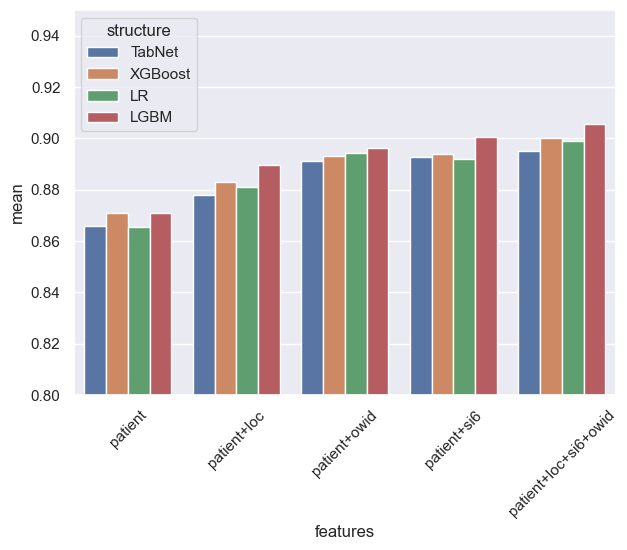

In [173]:
import seaborn as sns
sns.set_theme(style="darkgrid")

target_features = ['patient', 'patient+loc', 'patient+owid','patient+si6',  'patient+loc+si6+owid']
sorterIndex = dict(zip(target_features, range(len(target_features))))

# Generate a rank column that will be used to sort
df_plot = df_scall[df_scall['features'].isin(target_features)]
df_plot['feature_index'] = df_plot['features'].map(sorterIndex)
df_plot = df_plot.sort_values('feature_index')
                   
# Create the bar plot.
plt.figure(figsize=(7,5))
sns.barplot(x="features", y="mean", hue="structure", data=df_plot)
plt.ylim(0.8, .95)
plt.xticks(rotation=45)

# Show the plot.
plt.show()

# israel 결과 플롯

In [17]:
df_israel_result = pd.read_csv("../pipeline/output/israeli_result.csv")
df_israel_result

,month,auc1,auc2,auc3,auc4,auc5
0,2022-02,0.8125,0.7677,0.8246,0.7950,0.7902
1,2022-03,0.7538,0.7194,0.8267,0.8150,0.8681
2,2022-04,0.8523,0.8440,0.9212,0.8019,0.8815
3,2022-05,0.7910,0.8271,0.7687,0.7831,0.7898
4,2022-06,0.8488,0.8190,0.8681,0.8383,0.8588
5,2022-07,0.7877,0.8179,0.7640,0.7660,0.8785
6,2022-08,0.7429,0.6923,0.7725,0.8346,0.6956
7,2022-09,0.7640,0.6806,0.7731,0.7313,0.7252
8,2022-10,0.6523,0.6706,0.7008,0.7687,0.7371
9,2022-11,0.7450,0.8167,0.7621,0.7456,0.8048


In [28]:
df_israel_row = pd.DataFrame()

for index, row in df_israel_result.iterrows():
    month = row['month']
    for aucj, val in row.items():
        if 'auc' in aucj:
            j = aucj.split("auc")[-1]
            df_israel_row.loc[int(index)*10+int(j), 'month'] = month
            df_israel_row.loc[int(index)*10+int(j), 'AUROC'] = val

            
df_israel_row

,month,AUROC
1,2022-02,0.8125
2,2022-02,0.7677
3,2022-02,0.8246
4,2022-02,0.7950
5,2022-02,0.7902
11,2022-03,0.7538
12,2022-03,0.7194
13,2022-03,0.8267
14,2022-03,0.8150
15,2022-03,0.8681


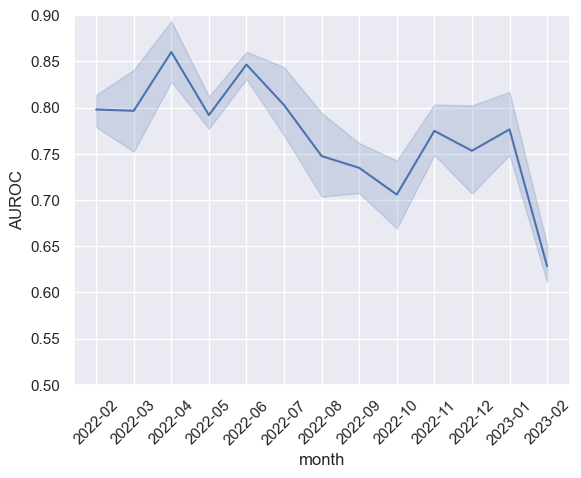

<Figure size 1400x500 with 0 Axes>

In [33]:
import seaborn as sns
sns.set()

sns.lineplot(data=df_israel_row, x='month', y='AUROC', markers=True, dashes=True)
plt.ylim(0.5, 0.9)
plt.xticks(rotation=45)
plt.figure(figsize=(14,5))
plt.show()